#### 1. Load the dataset

In [9]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Fetch the dataset (Statlog Vehicle Silhouettes)
vehicle_data = fetch_ucirepo(id=149)

# Features and target
X = vehicle_data.data.features
y = vehicle_data.data.targets

# Set the random seed for reproducibility
np.random.seed(777)


#### 2. Preprocess the Dataset

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

# Remove the class with 1 instance (class '204')
valid_classes = y['class'].value_counts()[lambda x: x > 1].index
mask = y['class'].isin(valid_classes)

X_filtered = X[mask].to_numpy()
y_filtered = y[mask].to_numpy().ravel()

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_filtered)

# Train (70%), Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, y_encoded, test_size=0.3, random_state=777, stratify=y_encoded
)

# Validation (15%), Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=777, stratify=y_temp
)

# Feature scaling (important!)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


#### 2. Neural Network Architecture

In [17]:
# Example neural network dimensions
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = len(np.unique(y_train))

# Weight initialization (from scratch)
np.random.seed(777)
W1 = np.random.randn(input_dim, hidden_dim) * 0.01
b1 = np.zeros((1, hidden_dim))

W2 = np.random.randn(hidden_dim, output_dim) * 0.01
b2 = np.zeros((1, output_dim))

# Activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Forward propagation
def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = sigmoid(Z1)  # or ReLU(Z1) if implemented in your notebook
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return A1, A2

# Loss (Cross-Entropy)
def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    log_probs = -np.log(y_pred[range(m), y_true] + 1e-9)
    loss = np.sum(log_probs) / m
    return loss

# Backward propagation and gradient descent
def backward_propagation(X, y_true, A1, A2, W2):
    m = X.shape[0]

    dZ2 = A2
    dZ2[range(m), y_true] -= 1
    dZ2 /= m

    dW2 = np.dot(A1.T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * A1 * (1 - A1)  # derivative of sigmoid

    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    return dW1, db1, dW2, db2

# Update weights
def update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate=0.1):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2


#### 3. Training

In [18]:
epochs = 1000
learning_rate = 0.1

for epoch in range(epochs):
    A1, A2 = forward_propagation(X_train, W1, b1, W2, b2)
    loss = cross_entropy_loss(y_train, A2)
    
    dW1, db1, dW2, db2 = backward_propagation(X_train, y_train, A1, A2, W2)
    W1, b1, W2, b2 = update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')


Epoch 0, Loss: 1.3861
Epoch 100, Loss: 1.3733
Epoch 200, Loss: 1.2895
Epoch 300, Loss: 1.1919
Epoch 400, Loss: 1.0749
Epoch 500, Loss: 0.9558
Epoch 600, Loss: 0.8526
Epoch 700, Loss: 0.7754
Epoch 800, Loss: 0.7201
Epoch 900, Loss: 0.6789


#### 4. Evaluation

              precision    recall  f1-score   support

         bus       0.76      0.88      0.81        32
        opel       0.70      0.44      0.54        32
        saab       0.69      0.73      0.71        33
         van       0.83      0.97      0.89        30

    accuracy                           0.75       127
   macro avg       0.74      0.75      0.74       127
weighted avg       0.74      0.75      0.73       127



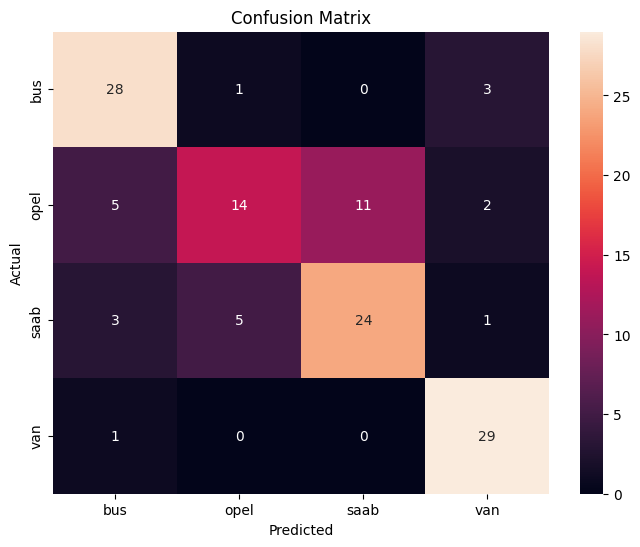

In [19]:
# Prediction function
def predict(X, W1, b1, W2, b2):
    _, A2 = forward_propagation(X, W1, b1, W2, b2)
    return np.argmax(A2, axis=1)

y_pred = predict(X_test, W1, b1, W2, b2)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
